In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from tqdm import tqdm
from sklearn.neural_network import MLPRegressor

np.random.seed(42)

dt = 0.02 # Time step
Cb1 = 24.9  # Example concentration for stream 1
Cb2 = 0.1  # Example concentration for stream 2
k1 = 1   # Reaction rate constant
k2 = 1   # Reaction rate parameter

# Initial conditions
h0 = 50.0  # Initial value of h(t)
Cb0 = 22 # Initial value of Cb(t)

# Time span
t_span = (0, 1500)  

### CSTR - Training data & ANN

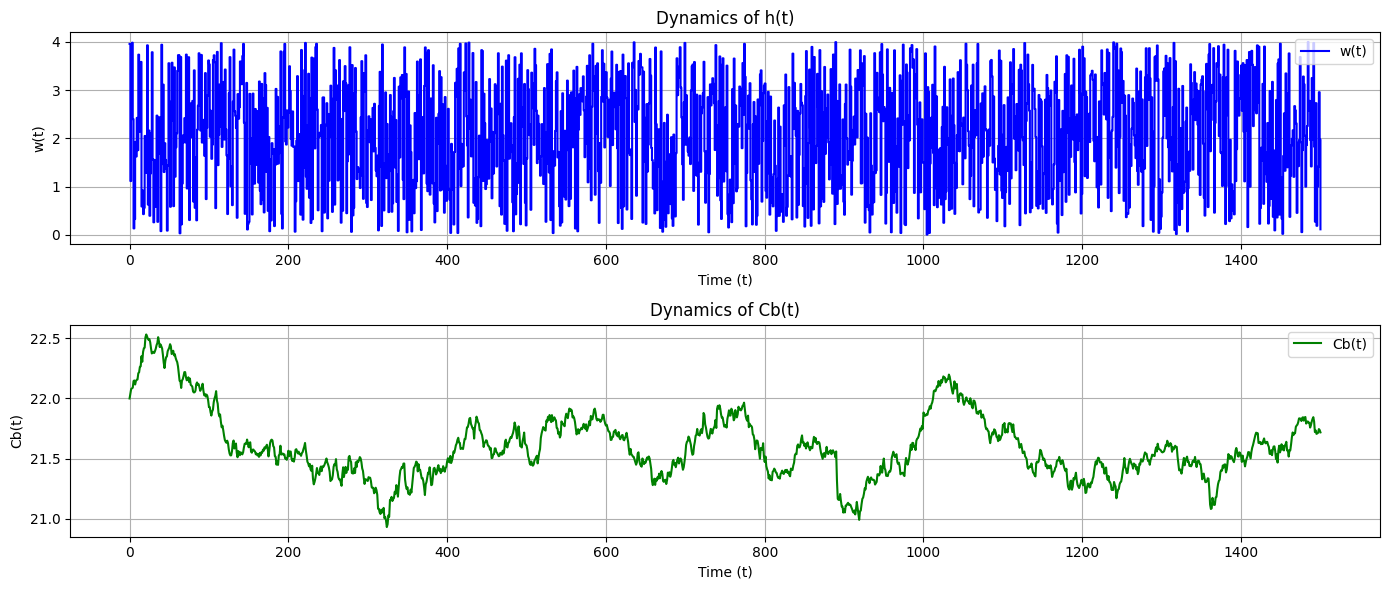

In [162]:
t_eval = np.arange(t_span[0], t_span[1] + dt, dt)

# Define the system of ODEs
def system_of_odes(t, y, w1, w2):
    h, Cb = y
    dh_dt = w1(t) + w2(t) - 0.2 * np.sqrt(h)
    dCb_dt = ((Cb1 - Cb) * w1(t) / h + (Cb2 - Cb) * w2(t) / h - k1 * Cb / (1 + k2 * Cb)**2) if h > 0 else 0
    return [dh_dt, dCb_dt]

# Example inputs for w1(t) and w2(t)
def w1(t):
    return np.random.uniform(0, 1) * 4

def w2(t):
    return 0.1

# Solve the system of ODEs
sol = solve_ivp(
    system_of_odes,
    t_span,
    [h0, Cb0],
    t_eval=t_eval,
    args=(w1, w2),
    method="RK45"
)

# Extract the solution
t = sol.t
h = sol.y[0]
Cb = sol.y[1]

# Plot the results
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.step(t, [w1(t) for t in t_eval], label="w(t)", color="blue", where='post')
plt.xlabel("Time (t)")
plt.ylabel("w(t)")
plt.title("Dynamics of h(t)")
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, Cb, label="Cb(t)", color="green")
plt.xlabel("Time (t)")
plt.ylabel("Cb(t)")
plt.title("Dynamics of Cb(t)")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


In [104]:
df = pd.DataFrame({'Time': sol.t, 'w1': [w1(t) for t in t_eval], 'Cb(t)': sol.y[1]})
print(df.shape)
df.head(3)

(1501, 3)


,Time,w1,Cb(t)
0,0,2.467399,22.500000
1,1,1.645745,22.516314
2,2,3.687338,22.535106


In [105]:
def prediction_plot(testY, test_predict) -> None:
    len_prediction=[x for x in range(len(testY))]
    plt.figure(figsize=(12,3))
    plt.plot(len_prediction, testY, marker='.', label="actual")
    plt.plot(len_prediction, test_predict, marker='.', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()
    
def convert2matrix(data_arr, look_back) -> tuple:
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,1:])
        Y.append(data_arr[d,2])
    return np.array(X), np.array(Y)

train_size = int(len(df) * 0.70)
train, test = df.values[0:train_size,:],df.values[train_size:len(df.values),:]
look_back = 1
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

# Reshape trainX and trainY to the shape of [samples, features]
trainX = np.reshape(trainX, (trainX.shape[0], 2))
testX = np.reshape(testX, (testX.shape[0], 2))

trainY = np.reshape(trainY, (trainY.shape[0],))
testY = np.reshape(testY, (testY.shape[0],))

print('Train and Test Shapes:')
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

Train and Test Shapes:
(1049, 2) (1049,) (450, 2) (450,)


In [106]:
# Create the MLP model
model = MLPRegressor(hidden_layer_sizes=(64,  64, 64), max_iter=1000, activation='relu', solver='adam', learning_rate_init=0.001, verbose=True)
model.fit(trainX, trainY)

Iteration 1, loss = 224.93119217
Iteration 2, loss = 149.06188715
Iteration 3, loss = 87.72231025
Iteration 4, loss = 39.73140059
Iteration 5, loss = 7.57820883
Iteration 6, loss = 1.36695336
Iteration 7, loss = 5.69105796
Iteration 8, loss = 2.43252056
Iteration 9, loss = 0.13329591
Iteration 10, loss = 0.62721153
Iteration 11, loss = 0.54289846
Iteration 12, loss = 0.08569804
Iteration 13, loss = 0.07241299
Iteration 14, loss = 0.10016964
Iteration 15, loss = 0.02876475
Iteration 16, loss = 0.02663899
Iteration 17, loss = 0.02903430
Iteration 18, loss = 0.01674684
Iteration 19, loss = 0.01642065
Iteration 20, loss = 0.01576672
Iteration 21, loss = 0.01331287
Iteration 22, loss = 0.01283121
Iteration 23, loss = 0.01167235
Iteration 24, loss = 0.01063472
Iteration 25, loss = 0.00942790
Iteration 26, loss = 0.00819091
Iteration 27, loss = 0.00675190
Iteration 28, loss = 0.00552350
Iteration 29, loss = 0.00437589
Iteration 30, loss = 0.00342552
Iteration 31, loss = 0.00261213
Iteration 3

MLPRegressor(hidden_layer_sizes=(64, 64, 64), max_iter=1000, verbose=True)

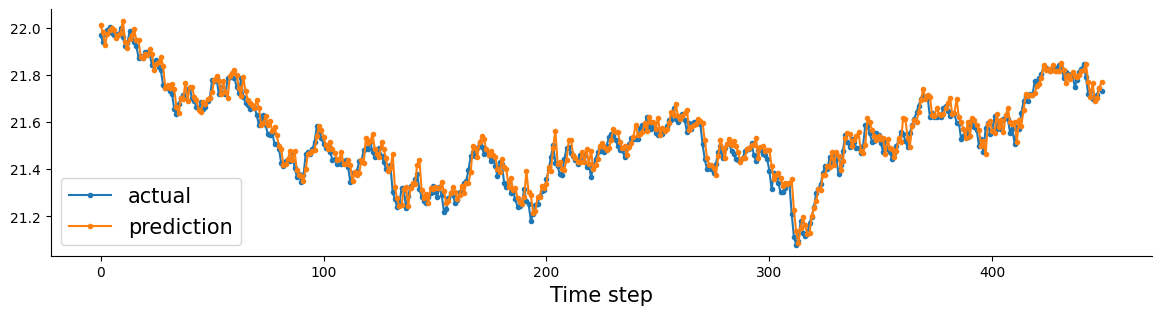

In [107]:
y_pred = model.predict(testX)
prediction_plot(testY, y_pred)

### Model Predictive Control

In [124]:
N_1 = 1
N_2 = 7
N_u = 2
rho = 0.05
alpha = 0.001

SP = 24

In [136]:
def cost_function(p_seq, y_init, t):
    y_pred = y_init
    J = 0.0
    
    for j in range(N_1, N_2):
        p = p_seq[min(j, N_u - 1)]
        # p = p_seq[j] if j < N_u else p_seq[-1]
        y_pred = model.predict([[p, y_pred]])[0]
        J += (y_pred - SP)**2 
    for j in range(1, N_u):
        J += rho * (p_seq[j] - p_seq[j - 1])**2  # Add squared control difference
    return J

def mpc_control(y, t):
    # p_init = np.linspace(0, 4, N_2)
    # p_init = np.random.uniform(0, 4, N_2)
    p_init = [2] * N_2
    result = minimize(cost_function, p_init, args=(y, t), bounds=[(0.1, 4)]*N_2)
    return result.x[0] if result.success else 0.0

# Simulation
time = np.arange(0, 120, dt)
y = 20
outputs = []
controls = []

for t in tqdm(range(1, len(time))):
    p_opt = mpc_control(y, t * dt)
    
    outputs.append(y)
    controls.append(p_opt)
    
    y = model.predict([[p_opt, y]])[0]

100%|██████████| 119/119 [00:02<00:00, 45.60it/s]


In [130]:
y = 20
for t in tqdm(range(1, len(time))):
    p_init = np.random.uniform(0, 4, N_2)
    print(p_init)
    
    if t == 3:
        break

  2%|▏         | 2/119 [00:00<00:00, 1999.19it/s]

[2.85072204 3.55255226 1.69901707 2.64479017 0.94151911 3.00440701
 2.32693401]
[1.92378045 2.77072644 2.20938108 3.06141949 3.43374427 3.20242522
 1.23002653]
[3.90447685 2.59896505 1.2938659  0.1703235  3.95238564 2.39606957
 0.91016105]


In [133]:
len(time), len(outputs), len(controls)

(120, 119, 119)

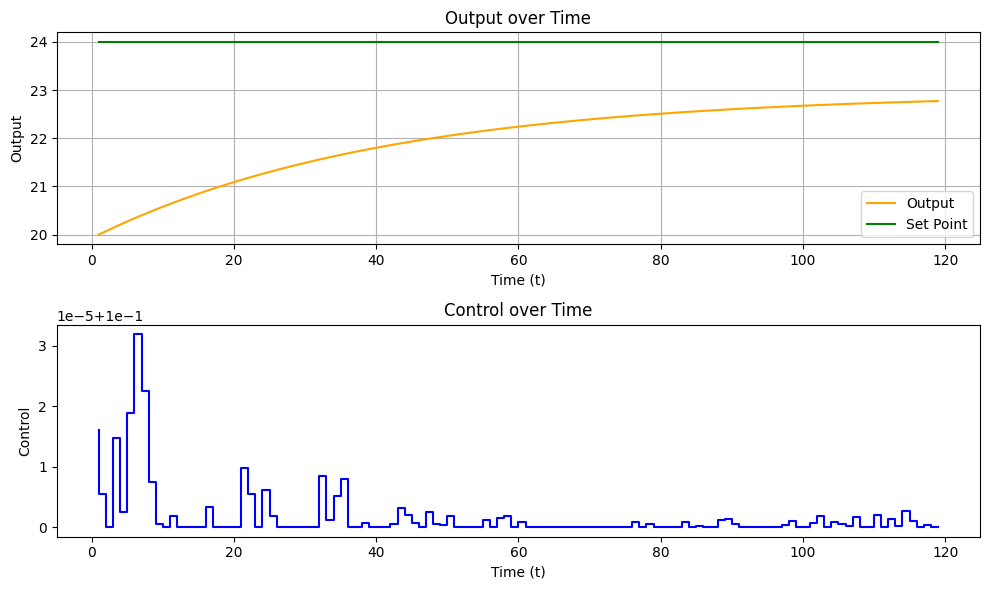

In [152]:
df = pd.DataFrame({'Time': time[1:], 'Output': outputs, 'Control': controls})

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# Plot the output
axs[0].plot(df['Time'], df['Output'], label='Output', color='orange')
axs[0].plot(df['Time'], [SP for t in time[1:]], label='Set Point', color='green') 
# axs[0].step(df['Time'], [set_point(t) for t in time[1:]], label='Set Point', color='green', where='post')
axs[0].set_xlabel('Time (t)')
axs[0].set_ylabel('Output')
axs[0].set_title('Output over Time')
axs[0].legend()
axs[0].grid()

# Plot the control
axs[1].step(df['Time'], df['Control'], label='Control', color='blue')
axs[1].set_xlabel('Time (t)')
axs[1].set_ylabel('Control')
axs[1].set_title('Control over Time')

plt.tight_layout()
plt.show()
